In [1]:
cd ..

C:\Users\dthiex\Documents\Fork\dton-wildfires-cleaner\notebooks


In [2]:
cd ..

C:\Users\dthiex\Documents\Fork\dton-wildfires-cleaner


In [3]:
import os

from sentinelhub import SHConfig, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, MimeType, DownloadRequest, CRS, BBox, SHConfig, bbox_to_dimensions, Geometry
from utils import plot_image

In [4]:
CLIENT_ID = os.environ['CLIENT_ID']
CLIENT_SECRET = os.environ['CLIENT_SECRET']

In [5]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

General idea:

- create water mask of S1 image during the event (flood) + 1 month before the event
- compare both water masks to get flooded areas

In [6]:
# Defining the bbox and resolution
resolution = 100
# when changing the location make sure to use dates where S1 IW VV excists
bbox = BBox(bbox=[53.974438, 36.783992, 54.731124, 37.122109], crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {bbox_size} pixels')

Image shape at 100 m resolution: (684, 356) pixels


In [7]:
# define dates (need to be dates where there is an S1 IW VV image)
before_flood_date = ('2019-03-05', '2019-03-05')
duing_flood_date = ('2019-03-29', '2019-03-29')

In [8]:
# data fusion between S1 
# in the evalscript the const water_threshold is used to distingues between water area and non water area (can be tested and modified in identify_flooded_areas notebook)

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [
        {datasource: "s1flood", bands: ["VV"]},
        {datasource: "s1beforeflood", bands: ["VV"]},
    ],
    output: { bands: 3 }
  }
}

function evaluatePixel(samples) {
    var s1flood = samples.s1flood[0];
    var s1beforeflood = samples.s1beforeflood[0];
    const water_threshold = 0.16
    const decible_gamma0_beforeflood = Math.max(0, Math.log(s1beforeflood.VV) * 0.21714724095 + 1);
    const decible_gamma0_flood = Math.max(0, Math.log(s1flood.VV) * 0.21714724095 + 1);
    if (decible_gamma0_flood < water_threshold & decible_gamma0_beforeflood > water_threshold)
       return [0, 0, 1]; //blue for flooded area
         else
       return [1, 1, 1]; //white for non flodded area
}
"""

In [9]:
# build processing request using above defined parameters (evalscript, bbox, size)
request_image = SentinelHubRequest(
  evalscript=evalscript,
  input_data=[
    SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1_IW_ASC,
        time_interval= before_flood_date,    
        other_args = {"id":"s1beforeflood","dataFilter":{"resolution":"HIGH"},"processing":{"orthorectify":"true","demInstance":"COPERNICUS","backCoeff":"GAMMA0_TERRAIN"}}
    ),
    SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1_IW_ASC,
        time_interval= duing_flood_date,
        other_args = {"id":"s1flood","dataFilter":{"resolution":"HIGH"},"processing":{"orthorectify":"true","demInstance":"COPERNICUS","backCoeff":"GAMMA0_TERRAIN"}}
    ),
  ],
  responses=[
    SentinelHubRequest.output_response('default', MimeType.PNG),
  ],
  bbox=bbox,  
  size=bbox_size,
  config=config
)

In [10]:
# request image from sh
testimage = request_image.get_data() 

Image type: uint8


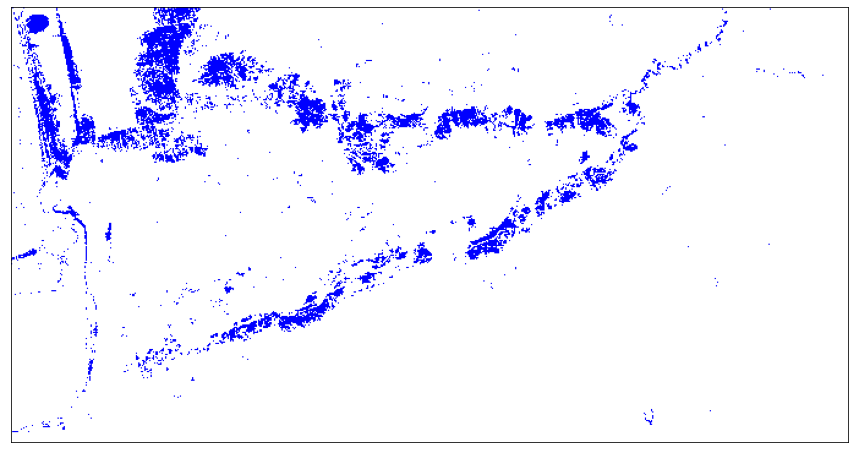

In [11]:
image = testimage[0]
print(f'Image type: {image.dtype}')

plot_image(image, factor=1/255)